# Required packages

In [ ]:
!pip install -U pandas-profiling

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas
import numpy
from pandas_profiling import ProfileReport
import seaborn
import matplotlib
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from google.colab import drive
drive.mount('/content/drive')
pandas.options.display.max_columns = None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration and Cleaning

## **What is a Credit Score?**

*A credit score is a numerical score, that is derived through statistical 
analysis, and represents a customer’s creditworthiness, i.e. its capacity to pay back credit obligations in a timely manner*

Load Data set and initial view

In [3]:
data = pandas.read_csv('/content/drive/MyDrive/ColabNotebooks/CreditScoreDataset/hashed_data.csv')
#Explore data set
data = data[(data['submission_date'] == 20210131) & (data['record_state'] ==1) & (data['borrower_classification']==0)].copy() # select submission date
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17172 entries, 2 to 41328
Data columns (total 58 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   submission_date                        17172 non-null  int64  
 1   create_date                            17172 non-null  int64  
 2   client_number                          17172 non-null  object 
 3   borrower_classification                17172 non-null  int64  
 4   credit_account_reference               17172 non-null  object 
 5   credit_account_date                    17172 non-null  int64  
 6   credit_amount                          16873 non-null  float64
 7   facility_amount_granted                299 non-null    float64
 8   credit_account_type                    17172 non-null  int64  
 9   reporting_date                         17172 non-null  int64  
 10  currency                               17172 non-null  object 
 11  op

In [4]:
# view sample data 
data.head(5)

submission_date  create_date                             client_number  \
2         20210131     20210215  9fc70bb0f6377bc06f00f2b851e0617b71f407fc   
4         20210131     20210215  f080fbc899273e2294a44c871e2356d4bc5c6840   
6         20210131     20210215  9a2fef1022169f47b2c8982218935db3182ebd05   
8         20210131     20210215  b39530f551f451da170425ffd8ca3c1a797057a9   
9         20210131     20210215  3466c26c112f97e2b66594c7fa0000ab3d020e16   

   borrower_classification credit_account_reference  credit_account_date  \
2                        0                1.014E+12             20151218   
4                        0              1.01704E+12             20191129   
6                        0                1.014E+12             20170511   
8                        0              1.01401E+12             20201111   
9                        0              1.01702E+12             20190514   

   credit_amount  facility_amount_granted  credit_account_type  \
2     10629644.0                      NaN                   10   
4    285000000.0                      NaN                    6   
6     14900000.0                      NaN                   10   
8    127000000.0                      NaN                   10   
9     28200000.0                      NaN                   10   

   reporting_date currency  opening_balance_indicator  maturity_date  \
2        20170630      UGX                          0       20190118   
4        20191129      UGX                          0       20260220   
6        20201123      UGX                          0       20211220   
8        20210129      UGX                          0       20261230   
9        20201123      UGX                          0       20230520   

   type_of_interest  interest_calculation_method  \
2               0.0                          0.0   
4               0.0                          0.0   
6               0.0                          0.0   
8               0.0                          0.0   
9               0.0                          0.0   

   annual_interest_rate_at_disbursement  annual_interest_rate_at_reporting  \
2                                  21.0                               21.0   
4                                   8.0                                8.0   
6                                  22.0                               22.0   
8                                  19.0                               19.0   
9                                  12.0                               12.0   

   date_of_first_payment  credit_amortization_type  credit_payment_frequency  \
2             20160118.0                         0                         5   
4             20191220.0                         0                         5   
6             20200820.0                         0                         5   
8             20210130.0                         0                         5   
9             20190520.0                         0                         5   

   number_of_payments  monthly_instalment_amount  current_balance_amount  \
2                37.0                        0.0              10115563.0   
4                75.0                  4841232.0             241383506.0   
6                17.0                   291112.0               2880955.0   
8                72.0                  2968844.0             125745663.0   
9                48.0                        0.0              18074307.0   

   current_balance_indicator  last_payment_date  date_settled  \
2                          1         20170630.0           NaN   
4                          0         20210120.0           NaN   
6                          0         20210121.0           NaN   
8                          0         20210130.0           NaN   
9                          0         20210120.0           NaN   

   last_payment_amount  credit_account_status  last_status_change_date  \
2              99000.0                      6                 201706

## **Explore Dataset and Dataset Attributes**



In [5]:
Exploration_report = ProfileReport(data, title='Dataset Overview', minimal = True)
Exploration_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## **Data cleaning Steps:**

1.   remove all date columns 
2.   remove all columns with greater than 50% missing data 
3.   remove contant columns i.e columns with 1 value


In [6]:
#  constant columns to delete
constant_cols = data.loc[:,data.apply(pandas.Series.nunique) == 1].columns.values.tolist()

# date columns 
date_columns = [col for col in data.columns.values.tolist() if "date" in col]

#other cols to drop 
other = ['client_number', 'credit_account_reference', 'currency','ii_fcs_number', 'ei_primary_occupation','days_in_arrears_pp']

#cols to delete (date cols and constanct columns)
cols_to_drop = (constant_cols + list(set(date_columns) - set(constant_cols)) + other)


# include colinear columns 
# cols_to_drop.extent('annual_interest_rate_at_reporting', 'current_balance_amount_ugx_equivalent', 'credit_amount_ugx_equivalent')
data.drop(columns=cols_to_drop, inplace=True)


# delete columns with more than 50% missing values 
data.dropna(thresh=data.shape[0]*0.2, how=all, axis=1, inplace=True)

# define target
data['credit_account_status'] =numpy.where(data.loc[:, 'credit_account_status'].isin([4,5]), 1, 0)

In [ ]:
Exploration_report2 = ProfileReport(data, title='Dataset Overview', minimal = True)
Exploration_report2.to_notebook_iframe()

## **Convert categorical columns from numeric to categorical, impute missing values** 

In [7]:
# Categorical cols i.e cols with atmost 15 unique values 
cat_cols = data.loc[:,data.apply(pandas.Series.nunique) <=15].columns.values.tolist()
cat_cols.remove('credit_account_status')

data[cat_cols] = data[cat_cols].astype('object')

#impute missing null Categorical columns with mode and missing nulls in numeric with mean 
 
# numeric columns
data.fillna(data.select_dtypes(exclude='object').mean(), inplace=True)

# categorical columns
data.fillna(data.select_dtypes(include='object').mode(), inplace=True)


#delete Numeric cols with more than 50% zeros 
colswithZeros = [col for col in data.select_dtypes(exclude='object').columns.values.tolist() if data[col][data[col]==0].count()/data[col].count() >0.5]
print(colswithZeros)

data.drop(columns=colswithZeros, inplace=True)

['number_of_days_in_arrears', 'balance_overdue']


## **Create dummies from categorical columns**

In [8]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pandas.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pandas.concat(df_dummies, axis = 1)
    df = pandas.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
data_with_dummy = dummy_creation(data, data.select_dtypes(include='object').columns.values.tolist())

## **Spliting the data into the training and test test for the scoring evaluation** 

In [9]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = data_with_dummy.drop('credit_account_status', axis = 1)
y = data_with_dummy['credit_account_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,  random_state =123, stratify = y)

#make true copies of traing and test
X_train, X_test = X_train.copy(), X_test.copy()

# Woe Bining 
(Calculating Weight of Evidence and Information Value of each of the predictor variables )

WOE( Weight Of Evidence): WoE is a measure of the predictive power of an independent variable in relation to the target variable. It measures the extent a specific feature can differentiate between target classes, in our case: good and bad customers

IV (Information Value): IV assists with ranking our features based on their relative importance.



In [10]:
import matplotlib.pyplot as plt

# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()


# calcuate WOE and information value 
def woe_discrete(df, cat_variabe_name, y_df):
    df = pandas.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pandas.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(), df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = numpy.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


# We set the default style of the graphs to the seaborn style. 
seaborn.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = numpy.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

## **WOE and Information Value for Categorical Variables**

column name: credit_account_type
 credit_account_type  n_obs  prop_good  prop_n_obs  n_good   n_bad  prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE   IV
                   7    225   0.364444    0.016379    82.0   143.0     0.007854    0.043373 -1.708757             NaN       NaN  inf
                   2     24   0.416667    0.001747    10.0    14.0     0.000958    0.004246 -1.489104        0.052222  0.219653  inf
                  11   1082   0.625693    0.078765   677.0   405.0     0.064847    0.122839 -0.638847        0.209026  0.850256  inf
                   6    399   0.734336    0.029046   293.0   106.0     0.028065    0.032150 -0.135898        0.108643  0.502949  inf
                  10  12001   0.780935    0.873626  9372.0  2629.0     0.897701    0.797392  0.118491        0.046599  0.254389  inf
                   0      6   1.000000    0.000437     6.0     0.0     0.000575    0.000000       inf        0.219065       inf  inf
None
column name: credit_payment_fre

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


None
column name: gscafb_gender
 gscafb_gender  n_obs  prop_good  prop_n_obs  n_good   n_bad  prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE       IV
           0.0   9745   0.735762    0.709398  7170.0  2575.0     0.686782    0.781013 -0.128575             NaN       NaN  0.04584
           1.0   3992   0.819138    0.290602  3270.0   722.0     0.313218    0.218987  0.357889        0.083376  0.486464  0.04584
None
column name: gscafb_marital_status
 gscafb_marital_status  n_obs  prop_good  prop_n_obs  n_good   n_bad  prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV
                   3.0     14   0.571429    0.001019     8.0     6.0     0.000766    0.001820 -0.864950             NaN       NaN  0.006681
                   7.0     59   0.677966    0.004295    40.0    19.0     0.003831    0.005763 -0.408191        0.106538  0.456758  0.006681
                   4.0     45   0.733333    0.003276    33.0    12.0     0.003161    0.003640 -0.141031        0.05

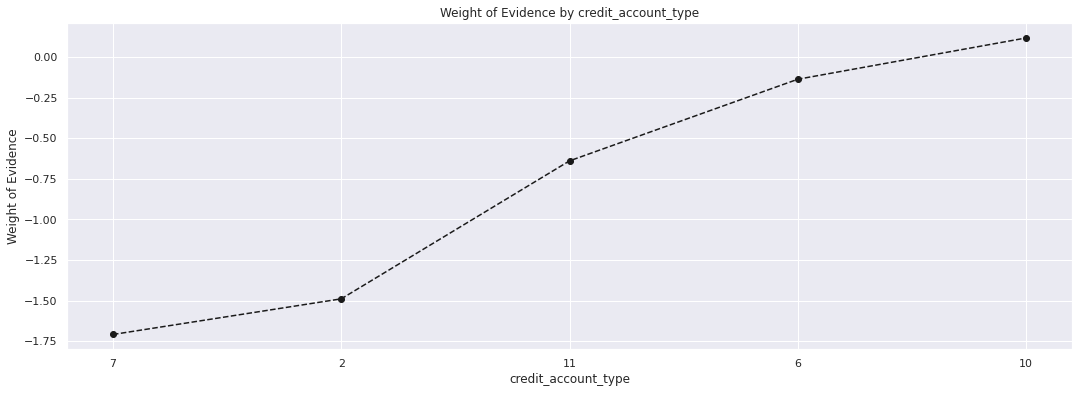

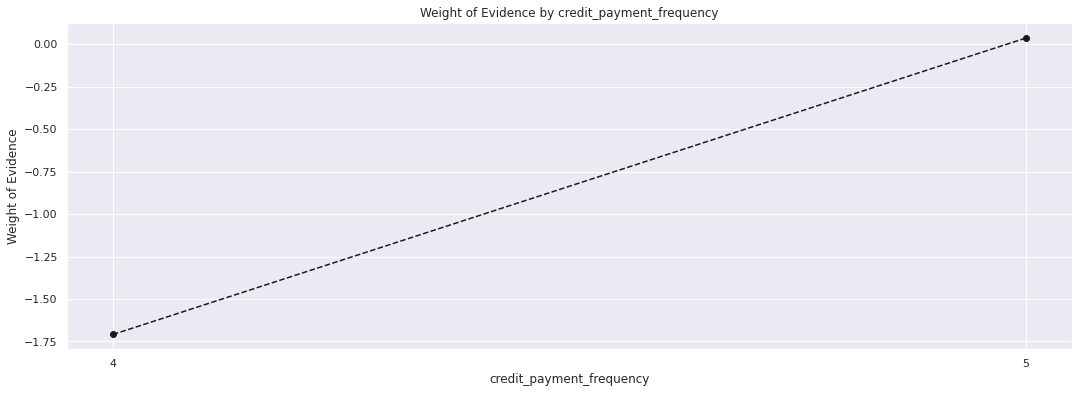

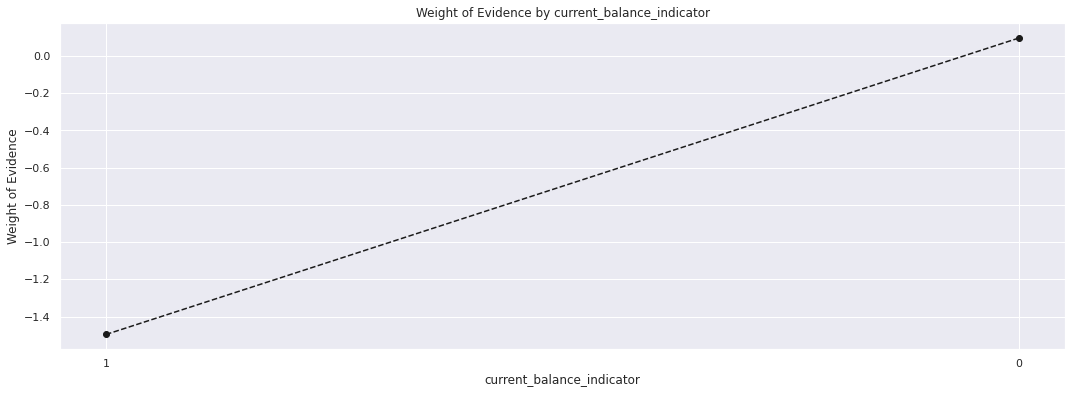

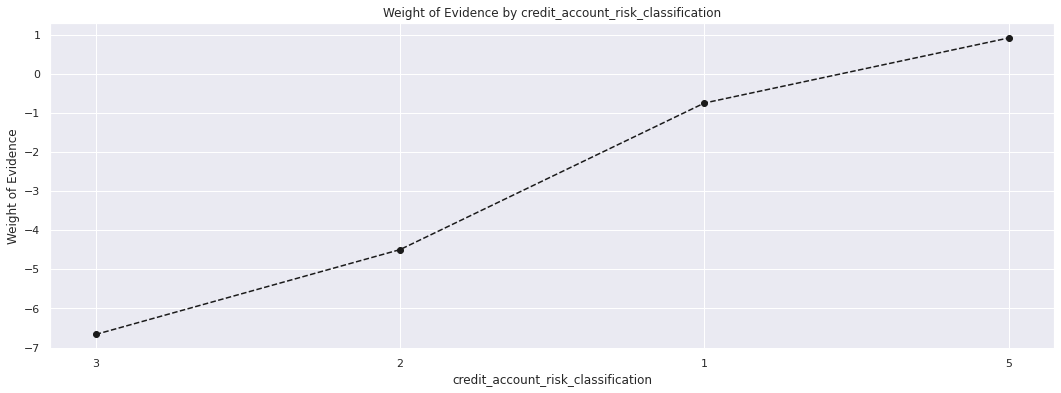

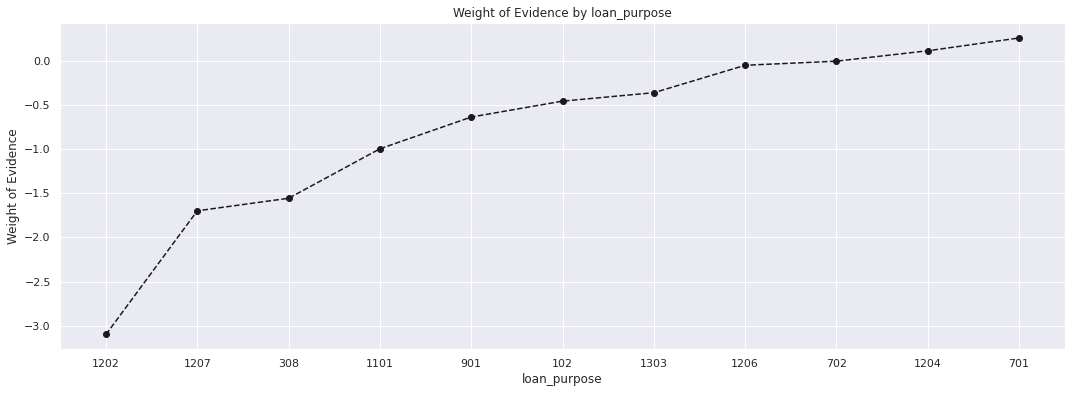

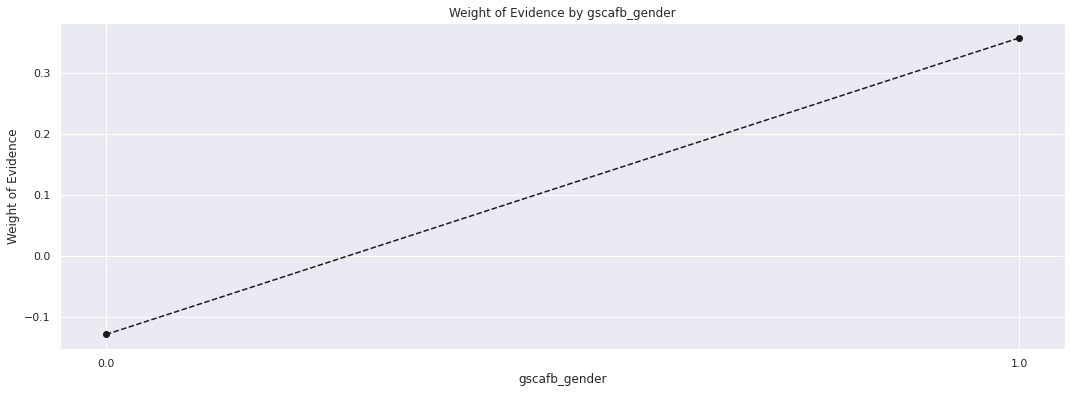

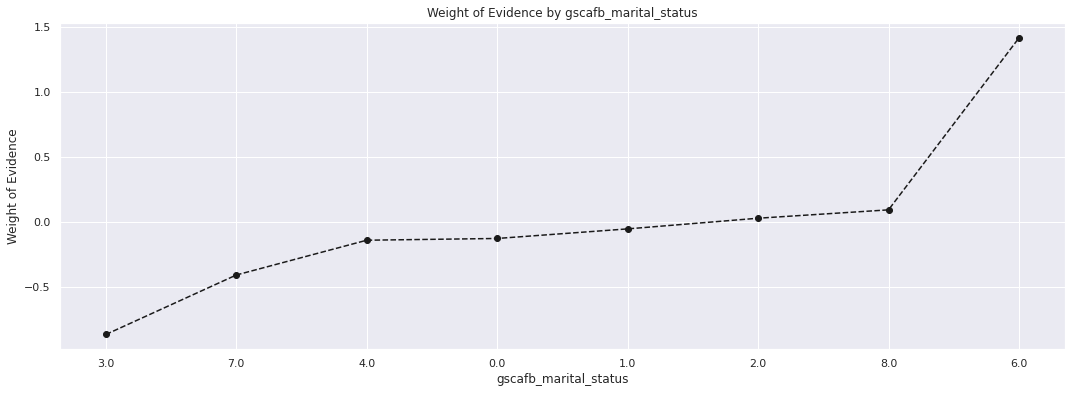

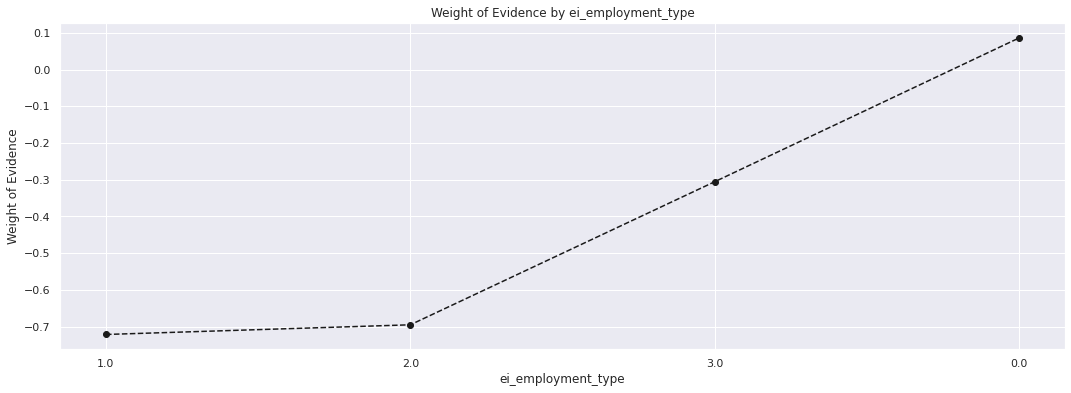

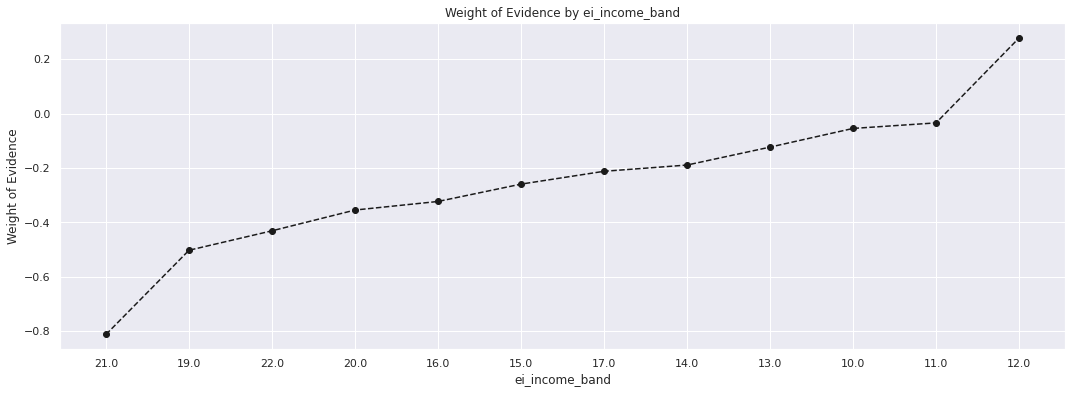

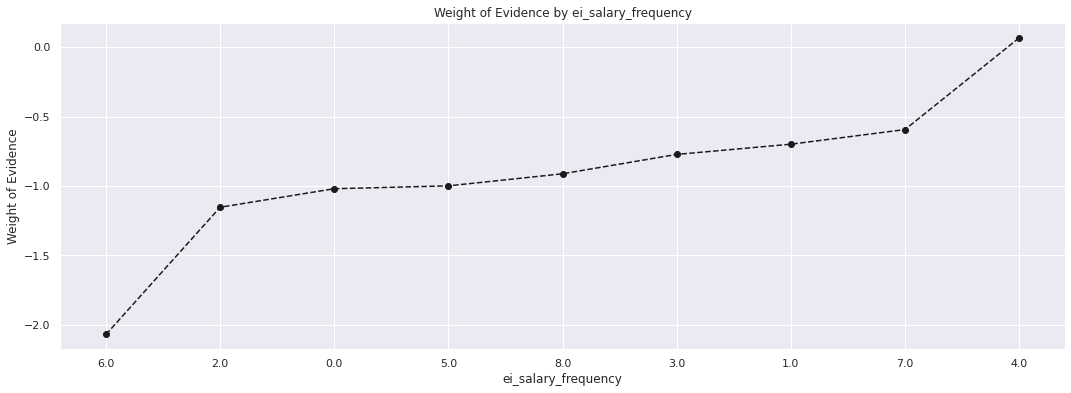

In [11]:
pandas.set_option('display.max_columns', None)
for col in data.select_dtypes(include='object').columns.values.tolist(): 
  df_temp = woe_discrete(X_train_prepr, col, y_train_prepr)
  print(f'column name: {col}')
  print(df_temp.to_string(index=False))
  print(plot_by_woe(df_temp))


**WOE and IV for numeric predictors**

In [12]:
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pandas.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pandas.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = numpy.log(df['prop_n_good'] / df['prop_n_bad'])
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

column name: credit_amount
[Interval(23100000.0, 26400000.0, closed='right'), Interval(6600000.0, 9900000.0, closed='right'), Interval(9900000.0, 13200000.0, closed='right'), Interval(3300000.0, 6600000.0, closed='right'), Interval(19800000.0, 23100000.0, closed='right'), Interval(6600000.0, 9900000.0, closed='right'), Interval(23100000.0, 26400000.0, closed='right'), Interval(9900000.0, 13200000.0, closed='right'), Interval(3300000.0, 6600000.0, closed='right'), Interval(9900000.0, 13200000.0, closed='right'), Interval(6600000.0, 9900000.0, closed='right'), Interval(6600000.0, 9900000.0, closed='right'), Interval(6600000.0, 9900000.0, closed='right'), Interval(9900000.0, 13200000.0, closed='right'), Interval(6600000.0, 9900000.0, closed='right'), Interval(6600000.0, 9900000.0, closed='right'), Interval(26400000.0, 29700000.0, closed='right'), Interval(13200000.0, 16500000.0, closed='right'), Interval(6600000.0, 9900000.0, closed='right'), Interval(3300000.0, 6600000.0, closed='right')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



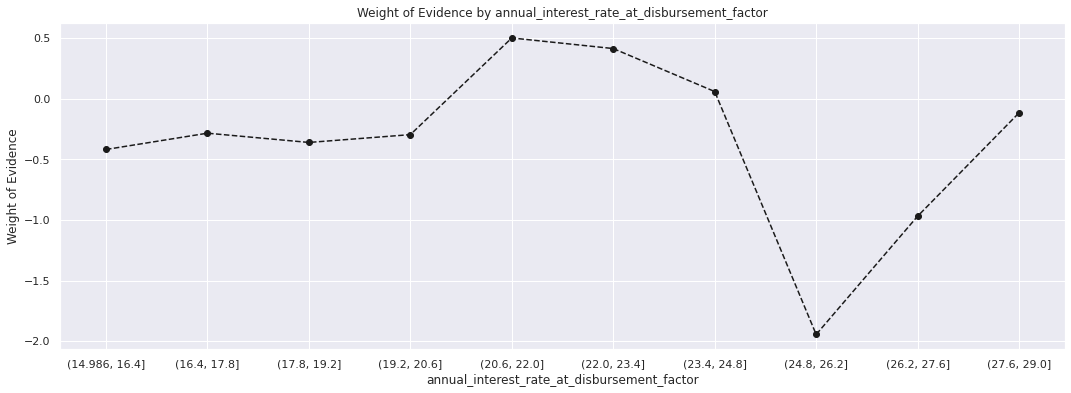

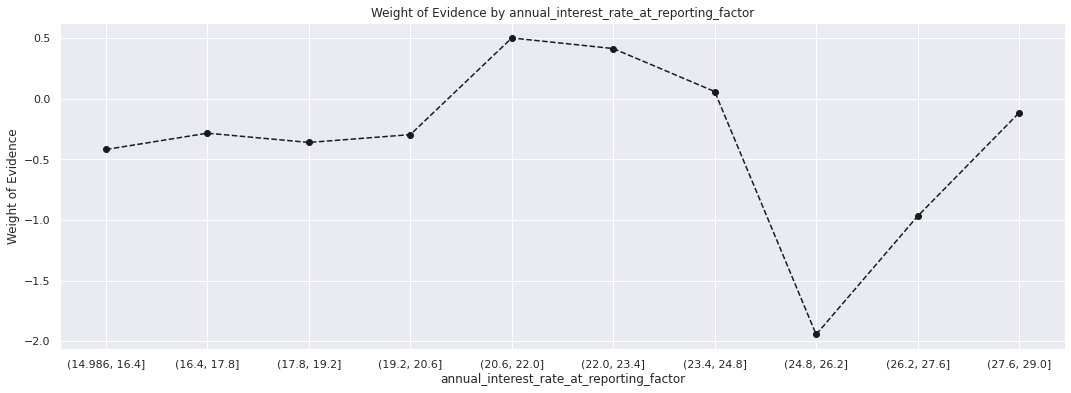

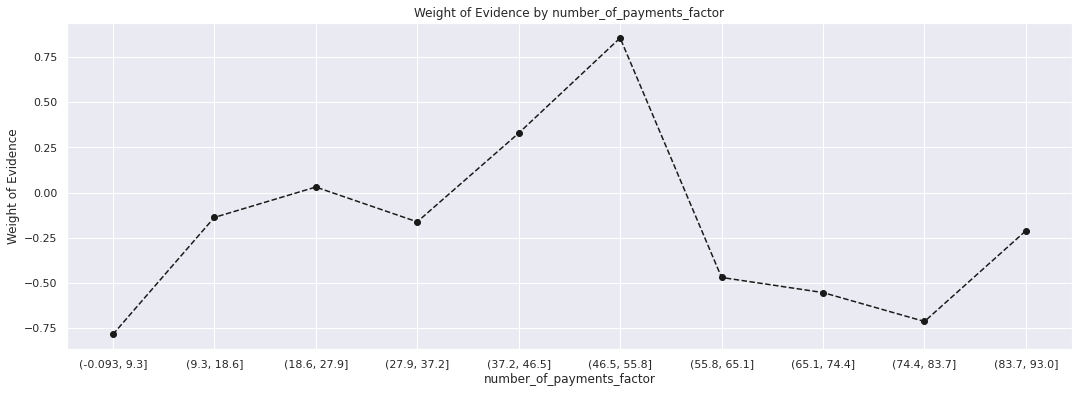

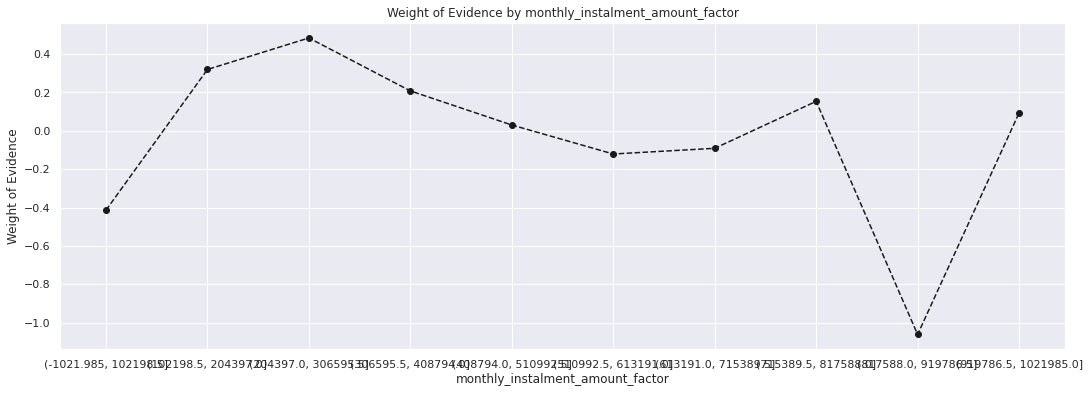

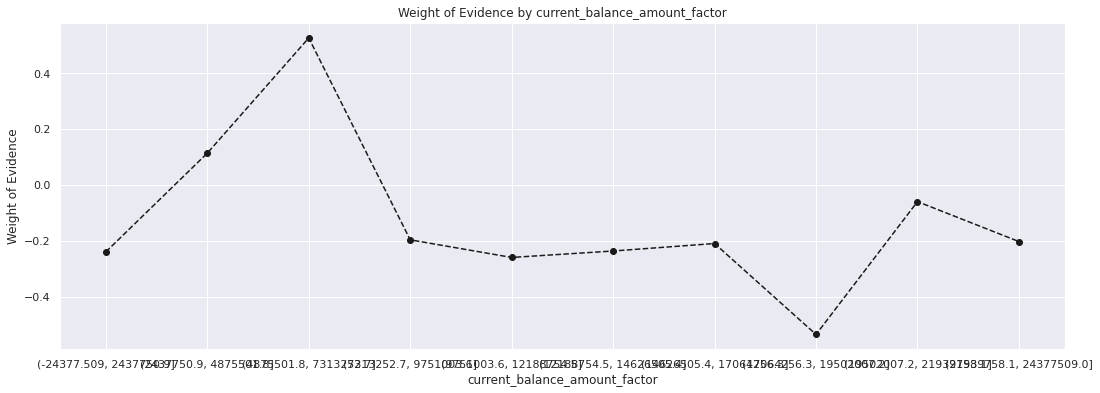

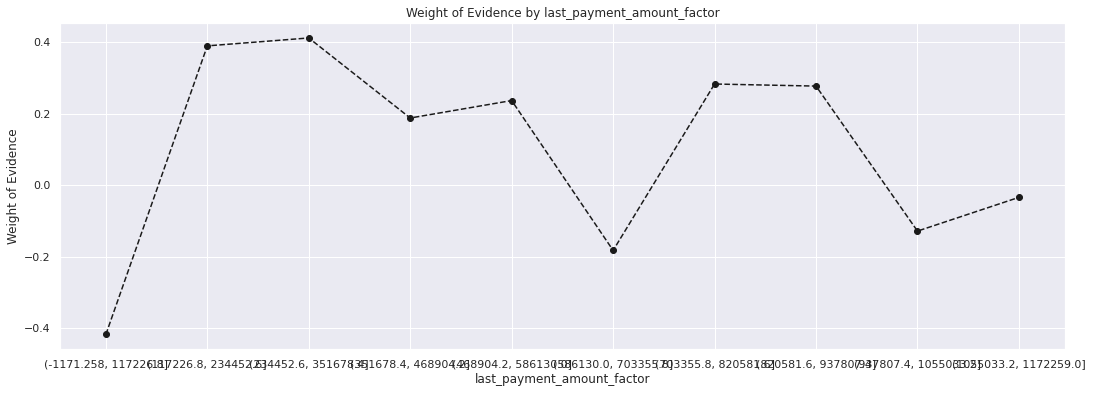

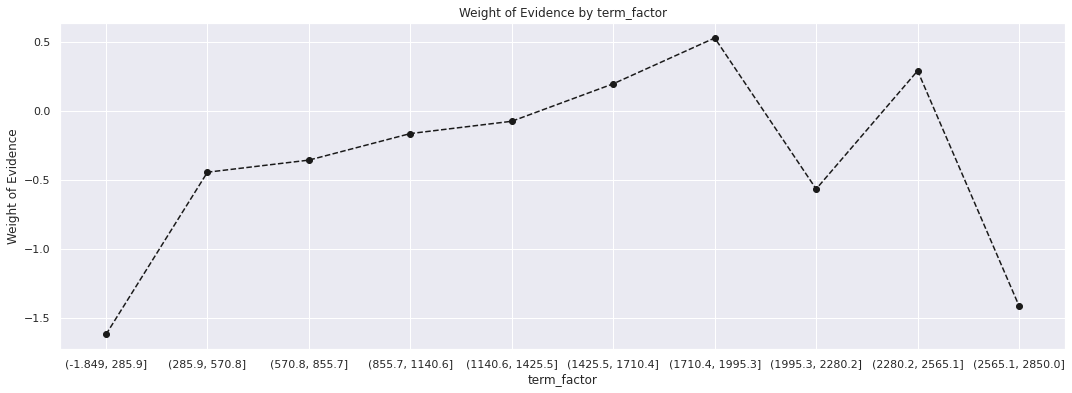

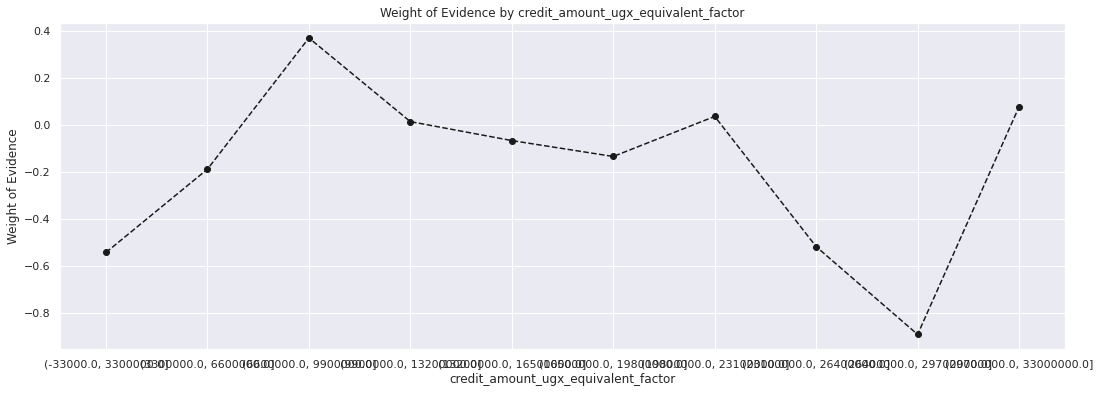

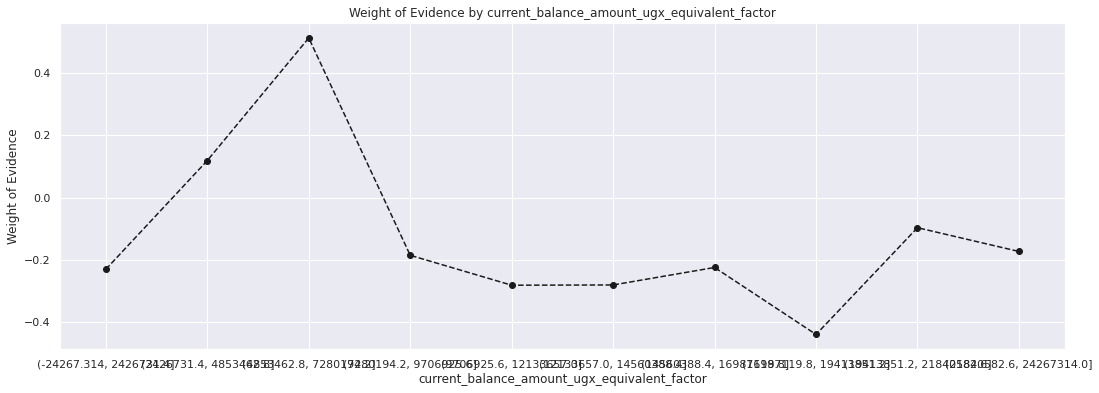

In [13]:
numerical_cols = data.select_dtypes(exclude='object').columns.values.tolist()
numerical_cols.remove('credit_account_status')

for col in numerical_cols: 
    print(f'column name: {col}')

    # remove the outliers 
    q1 = X_train_prepr[col].quantile(0.25)
    q3 = X_train_prepr[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    X_train_prepr_temp = X_train_prepr.loc[(X_train_prepr[col] > fence_low) & (X_train_prepr[col] < fence_high)].copy()


    X_train_prepr_temp[f'{col}_factor'] = pandas.cut(X_train_prepr_temp[col], 10) 
    print(X_train_prepr_temp[f'{col}_factor'].values.tolist())
    df_temp = woe_ordered_continuous(X_train_prepr_temp, f'{col}_factor', y_train_prepr[X_train_prepr_temp.index])
    
    #
    print(df_temp.to_string(index=False))
    print(plot_by_woe(df_temp))



## **New Binning Base on WOE and IV**

In [ ]:
# credit amount bins
X_new['credit_amount:0-3300000'] = numpy.where((X['credit_amount'] <= 3300000), 1, 0)
X_new['credit_amount:3300001 - 6600000'] = numpy.where((X['credit_amount'] >3300000 ) & (X['credit_amount'] <= 6600000.0), 1, 0)
X_new['credit_amount:6600000 - 9900000.0'] = numpy.where((X['credit_amount'] >6600000 ) & (X['credit_amount'] <= 9900000.0), 1, 0)
X_new['credit_amount:9900000 - 13200000.0'] = numpy.where((X['credit_amount'] >9900000 ) & (X['credit_amount'] <= 13200000.0), 1, 0)
X_new['credit_amount:13200000 - 16500000.0'] = numpy.where((X['credit_amount'] >13200000 ) & (X['credit_amount'] <= 16500000.0), 1, 0)
X_new['credit_amount:16500000 - 19800000.0'] = numpy.where((X['credit_amount'] >16500000 ) & (X['credit_amount'] <= 19800000.0), 1, 0)
X_new['credit_amount:13200000 - 16500000.0'] = numpy.where((X['credit_amount'] >13200000 ) & (X['credit_amount'] <= 16500000.0), 1, 0)
X_new['credit_amount:13200000 - 16500000.0'] = numpy.where((X['credit_amount'] >13200000 ) & (X['credit_amount'] <= 16500000.0), 1, 0)
X_new['credit_amount:13200000 - 16500000.0'] = numpy.where((X['credit_amount'] >13200000 ) & (X['credit_amount'] <= 16500000.0), 1, 0)
X_new['credit_amount:13200000 - 16500000.0'] = numpy.where((X['credit_amount'] >13200000 ) & (X['credit_amount'] <= 16500000.0), 1, 0)
X_new['credit_amount:13200000 - 16500000.0'] = numpy.where((X['credit_amount'] >13200000 ) & (X['credit_amount'] <= 16500000.0), 1, 0)
X_new['credit_amount: 19800000 - 23100000.0'] = numpy.where((X['credit_amount'] >19800000) & (X['credit_amount']<= 23100000.0), 1, 0) 
X_new['credit_amount: 23100000 - 26400000.0'] = numpy.where((X['credit_amount'] >23100000) & (X['credit_amount']<= 26400000.0), 1, 0)
X_new['credit_amount: 26400000 - 29700000.0'] = numpy.where((X['credit_amount'] >26400000) & (X['credit_amount']<= 29700000.0), 1, 0)
X_new['credit_amount: 29700000 - 33000000.0'] = numpy.where((X['credit_amount'] >29700000), 1, 0)

# annual_intrest_rate_at_disbursment 
X_new['annual_interest_rate_at_disbursement:0 - 16.4'] = numpy.where((X['annual_interest_rate_at_disbursement'] >=0) & (X['annual_interest_rate_at_disbursement'] <= 16.4),1,0)
X_new['annual_interest_rate_at_disbursement:17.8 - 19.2'] = numpy.where((X['annual_interest_rate_at_disbursement'] >17.8) & (X['annual_interest_rate_at_disbursement'] <= 19.2),1,0)
X_new['annual_interest_rate_at_disbursement:19.2 - 20.6'] = numpy.where((X['annual_interest_rate_at_disbursement'] >19.2) & (X['annual_interest_rate_at_disbursement'] <= 20.6),1,0)
X_new['annual_interest_rate_at_disbursement:20.6 - 22.0'] = numpy.where((X['annual_interest_rate_at_disbursement'] >20.6) & (X['annual_interest_rate_at_disbursement'] <= 22.0),1,0)
X_new['annual_interest_rate_at_disbursement:22.0 - 23.4'] = numpy.where((X['annual_interest_rate_at_disbursement'] >22.0) & (X['annual_interest_rate_at_disbursement'] <= 23.4),1,0)
X_new['annual_interest_rate_at_disbursement:23.4 - 24.8'] = numpy.where((X['annual_interest_rate_at_disbursement'] >23.4) & (X['annual_interest_rate_at_disbursement'] <= 24.8),1,0)
X_new['annual_interest_rate_at_disbursement:24.8 - 26.2'] = numpy.where((X['annual_interest_rate_at_disbursement'] >24.8) & (X['annual_interest_rate_at_disbursement'] <= 26.2),1,0)
X_new['annual_interest_rate_at_disbursement:26.2 - 27.6'] = numpy.where((X['annual_interest_rate_at_disbursement'] >26.2) & (X['annual_interest_rate_at_disbursement'] <= 27.6),1,0)
X_new['annual_interest_rate_at_disbursement:27.6 - 29.0'] = numpy.where((X['annual_interest_rate_at_disbursement'] >27.6),1,0)

#annual_interest_rate_at_reporting
X_new['annual_interest_rate_at_reporting:0 - 16.4'] = numpy.where((X['annual_interest_rate_at_reporting'] >=0) & (X['annual_interest_rate_at_reporting'] <= 16.4),1,0)
X_new['annual_interest_rate_at_reporting:17.8 - 19.2'] = numpy.where((X['annual_interest_rate_at_reporting'] >17.8) & (X['annual_interest_rate_at_reporting'] <= 19.2),1,0)
X_new['annual_interest_rate_at_reporting:19.2 - 20.6'] = numpy.where((X['annual_interest_rate_at_reporting'] >19.2) & (X['annual_interest_rate_at_reporting'] <= 20.6),1,0)
X_new['annual_interest_rate_at_reporting:20.6 - 22.0'] = numpy.where((X['annual_interest_rate_at_reporting'] >20.6) & (X['annual_interest_rate_at_reporting'] <= 22.0),1,0)
X_new['annual_interest_rate_at_reporting:22.0 - 23.4'] = numpy.where((X['annual_interest_rate_at_reporting'] >22.0) & (X['annual_interest_rate_at_reporting'] <= 23.4),1,0)
X_new['annual_interest_rate_at_reporting:23.4 - 24.8'] = numpy.where((X['annual_interest_rate_at_reporting'] >23.4) & (X['annual_interest_rate_at_reporting'] <= 24.8),1,0)
X_new['annual_interest_rate_at_reporting:24.8 - 26.2'] = numpy.where((X['annual_interest_rate_at_reporting'] >24.8) & (X['annual_interest_rate_at_reporting'] <= 26.2),1,0)
X_new['annual_interest_rate_at_reporting:26.2 - 27.6'] = numpy.where((X['annual_interest_rate_at_reporting'] >26.2) & (X['annual_interest_rate_at_reporting'] <= 27.6),1,0)
X_new['annual_interest_rate_at_reporting:27.6 - 29.0'] = numpy.where((X['annual_interest_rate_at_reporting'] >27.6),1,0)


number_of_payments

(0.00, 9.30]
(9.30, 18.6]
(18.6, 27.9]
(27.9, 37.2]
(37.2, 46.5]
(46.5, 55.8]
(55.8, 65.1]
(65.1, 74.4]
(74.4, 83.7]
(83.7, 93.0]